In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter

def plot_av_vs_as(gdf: gpd.GeoDataFrame, As_Kategorie: str, Kategorie: str, Titel: str):
    """
    Vergleicht zwei Kategorisierungsspalten in einem GeoDataFrame und erstellt eine
    Karte + Balkendiagramm mit Übereinstimmungsraten.
    """

    # Sicherstellen, dass CRS metrisch ist (EPSG:2056)
    if gdf.crs is None or gdf.crs.to_epsg() != 2056:
        gdf = gdf.to_crs(epsg=2056)

    # Farben definieren
    category_colors = {
        1: "#228B22",  # Forest land
        2: "#8B4513",  # Cropland
        3: "#BCFF1E",  # Grassland
        4: "#1E90FF",  # Wetlands
        5: "#A9A9A9",  # Settlements
        6: "#F31383"   # Other Land
    }

    def adjust_brightness(color, factor):
        rgb = np.array(to_rgb(color))
        rgb = np.clip(rgb * factor, 0, 1)
        return rgb

    # Hell = korrekt, kräftig = falsch
    color_low_sat = {k: adjust_brightness(v, 1.5) for k, v in category_colors.items()}
    color_high_sat = {k: adjust_brightness(v, 1.0) for k, v in category_colors.items()}

    # Farbe pro Polygon zuweisen
    def get_color(row):
        a_cat = row[As_Kategorie]  # True category (As wird als Referenz genutzt)
        b_cat = row[Kategorie]    # Predicted category
        return color_low_sat[a_cat] if a_cat == b_cat else color_high_sat[a_cat]

    gdf["plot_color"] = gdf.apply(get_color, axis=1)

    # Übereinstimmungsraten pro Kategorie
    accuracy_per_class = []
    for cat in category_colors.keys():
        mask = gdf[As_Kategorie] == cat
        correct = np.sum(gdf.loc[mask, Kategorie] == cat)
        total = np.sum(mask)
        pct = (correct / total * 100) if total > 0 else 0
        accuracy_per_class.append((cat, pct))

    # Sortierung der Kategorien nach Häufigkeit (absteigend)
    category_counts = gdf[As_Kategorie].value_counts()
    ordered_cats = list(category_counts.index)

    # Berechnung der Balkenhöhen: Häufigkeit → Höhe (0.2 bis 1.0)
    heights = {}
    max_count = category_counts.max()
    min_count = category_counts.min()
    min_h = 0.2
    max_h = 1.0

    for cat in ordered_cats:
        count = category_counts[cat]
        if max_count == min_count:
            h = 1.0
        else:
            h = min_h + (count - min_count) / (max_count - min_count) * (max_h - min_h)
        heights[cat] = h

    # Sortierte Accuracy-Liste
    accuracy_per_class_ordered = [
        (cat, next(pct for (c, pct) in accuracy_per_class if c == cat))
        for cat in ordered_cats
    ]

    # Plot: Karte + Balken
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[2, 1])

    # --- K A R T E ---
    gdf.plot(ax=ax_map, color=gdf["plot_color"], edgecolor="none", linewidth=0.2)

    ax_map.set_title(Titel, fontsize=18, fontweight="bold")
    ax_map.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # --- ACHSEN OHNE WISSENSCHAFTLICHE NOTATION ---
    formatter = ScalarFormatter(useMathText=False)
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    ax_map.xaxis.set_major_formatter(formatter)
    ax_map.yaxis.set_major_formatter(formatter)

    # Tausendertrennzeichen mit Leerzeichen
    ax_map.get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: f"{int(x):,}".replace(",", " "))
    )
    ax_map.get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda y, p: f"{int(y):,}".replace(",", " "))
    )

    # Maßstab
    xlim = ax_map.get_xlim()
    ylim = ax_map.get_ylim()
    scalebar_length = 100000
    scalebar_x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
    scalebar_y = ylim[0] + (ylim[1] - ylim[0]) * 0.02

    ax_map.plot([scalebar_x, scalebar_x + scalebar_length],
                [scalebar_y, scalebar_y], color='black', linewidth=3)
    ax_map.text(
        scalebar_x + scalebar_length / 2,
        scalebar_y + (ylim[1] - ylim[0]) * 0.01,
        f"{scalebar_length} m",
        ha='center',
        fontsize=10
    )

    # Kategorie-Namen
    category_names = {
        1: "Forest land",
        2: "Cropland",
        3: "Grassland",
        4: "Wetlands",
        5: "Settlements",
        6: "Other Land"
    }

    # --- B A L K E N ---
    for idx, (cat, pct) in enumerate(accuracy_per_class_ordered):
        incorrect = 100 - pct
        h = heights[cat]

        ax_bar.barh(idx, pct, height=h, color=color_low_sat[cat], edgecolor="black")
        ax_bar.barh(idx, incorrect, left=pct, height=h, color=color_high_sat[cat], edgecolor="black")

    ax_bar.set_yticks(range(len(ordered_cats)))
    ax_bar.set_yticklabels(
        [f"{category_names[cat]} {pct:.0f}%" for (cat, pct) in accuracy_per_class_ordered]
    )
    ax_bar.set_xlim(0, 100)
    ax_bar.set_xlabel("Prozentuale Übereinstimmung")
    ax_bar.set_title("Kategorie mit Prozent Übereinstimmung", fontsize=12, fontweight="bold")

    # Legende korrekt / falsch
    legend_patches = [
        mpatches.Patch(color="lightgrey", label="hell = korrekt"),
        mpatches.Patch(color="darkgrey", label="dunkel = falsch")
    ]

    ax_bar.legend(
        handles=legend_patches,
        loc="upper center",
        ncol=2,
        frameon=False,
        fontsize=8
    )

    ax_bar.invert_yaxis()

    plt.tight_layout()
    plt.show()


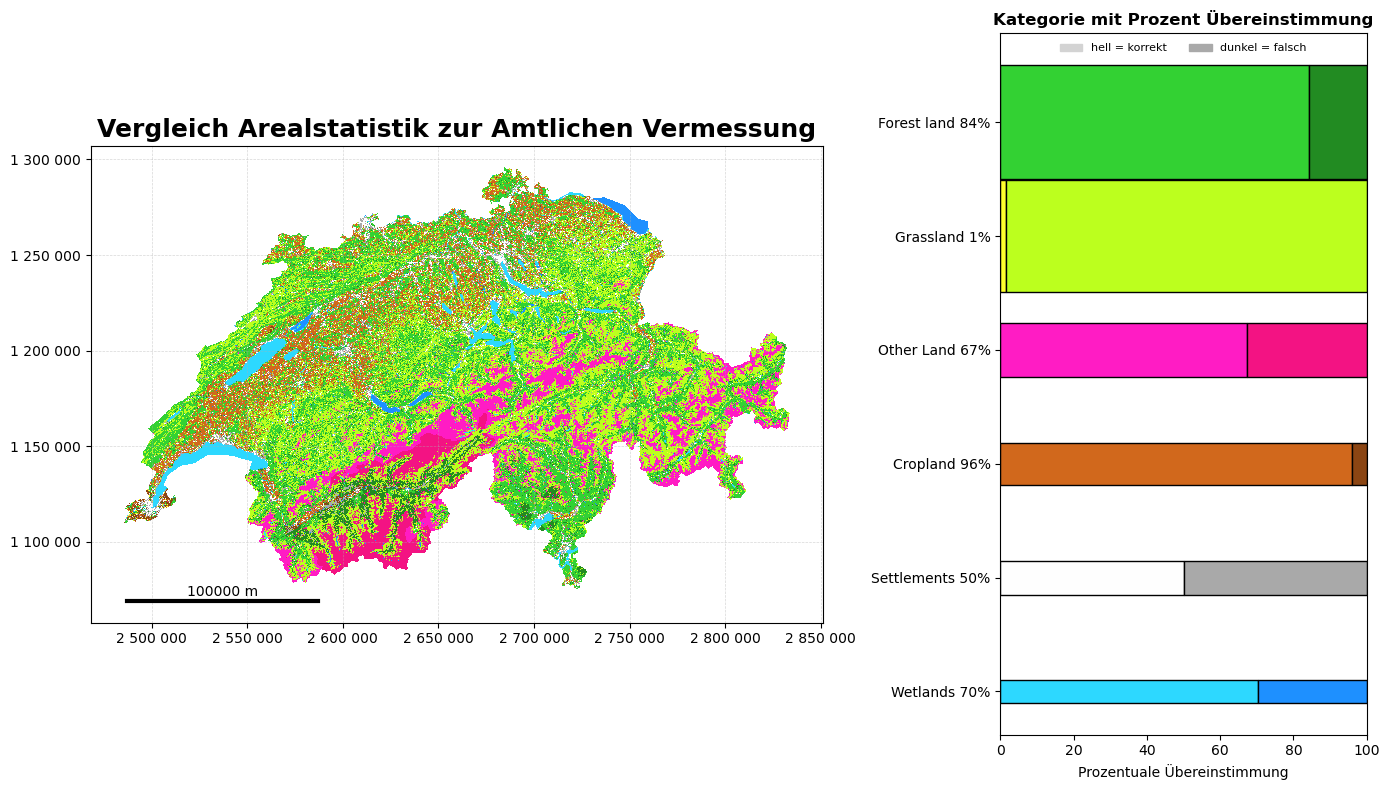

In [ ]:
# gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_AV_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Vergleich Arealstatistik zur Amtlichen Vermessung" )


In [ ]:
# gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Maximal_Area.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_AV_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Vergleich Arealstatistik zur Amtlichen Vermessung" )

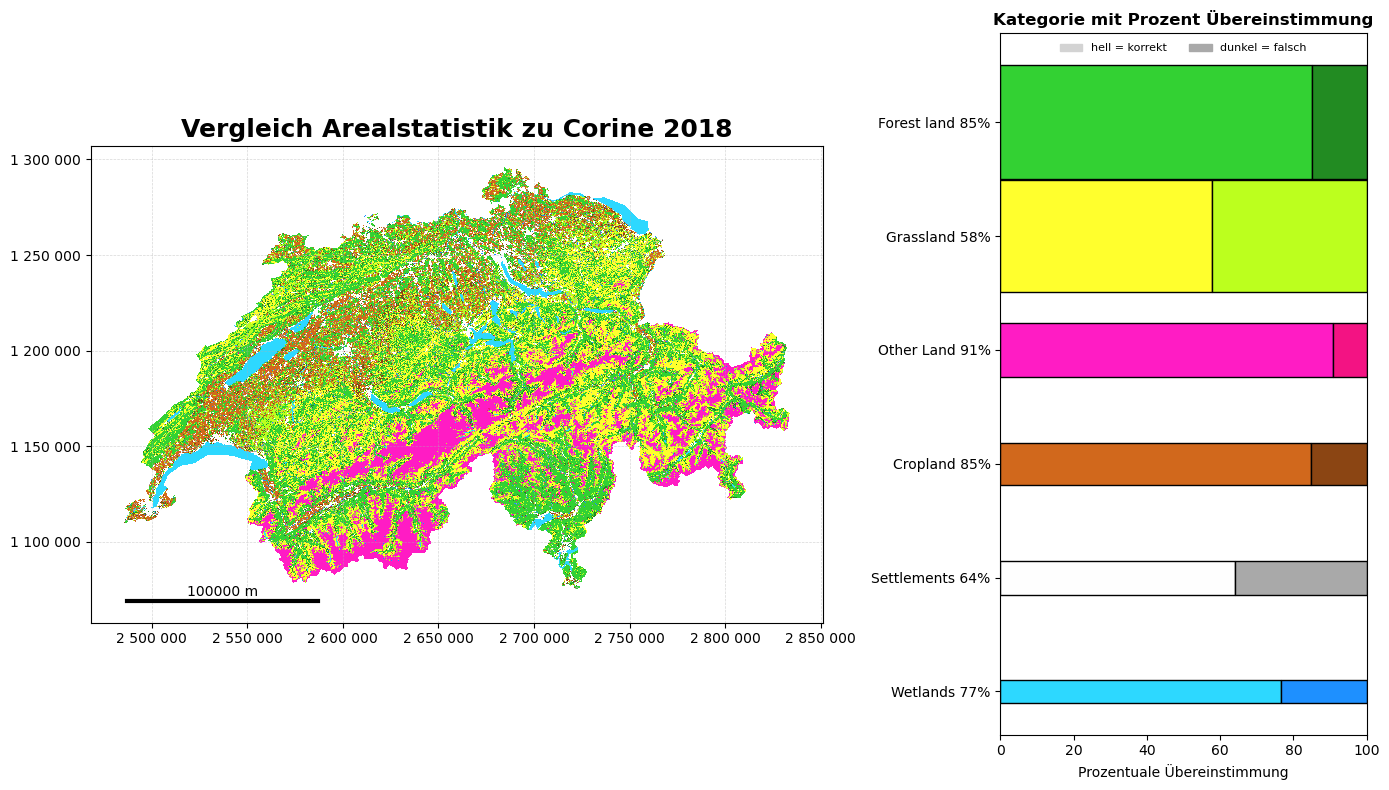

In [13]:
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\corine\areal_corine_ipcc_2018_max_area.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_CORINE_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Vergleich Arealstatistik zu Corine 2018" )

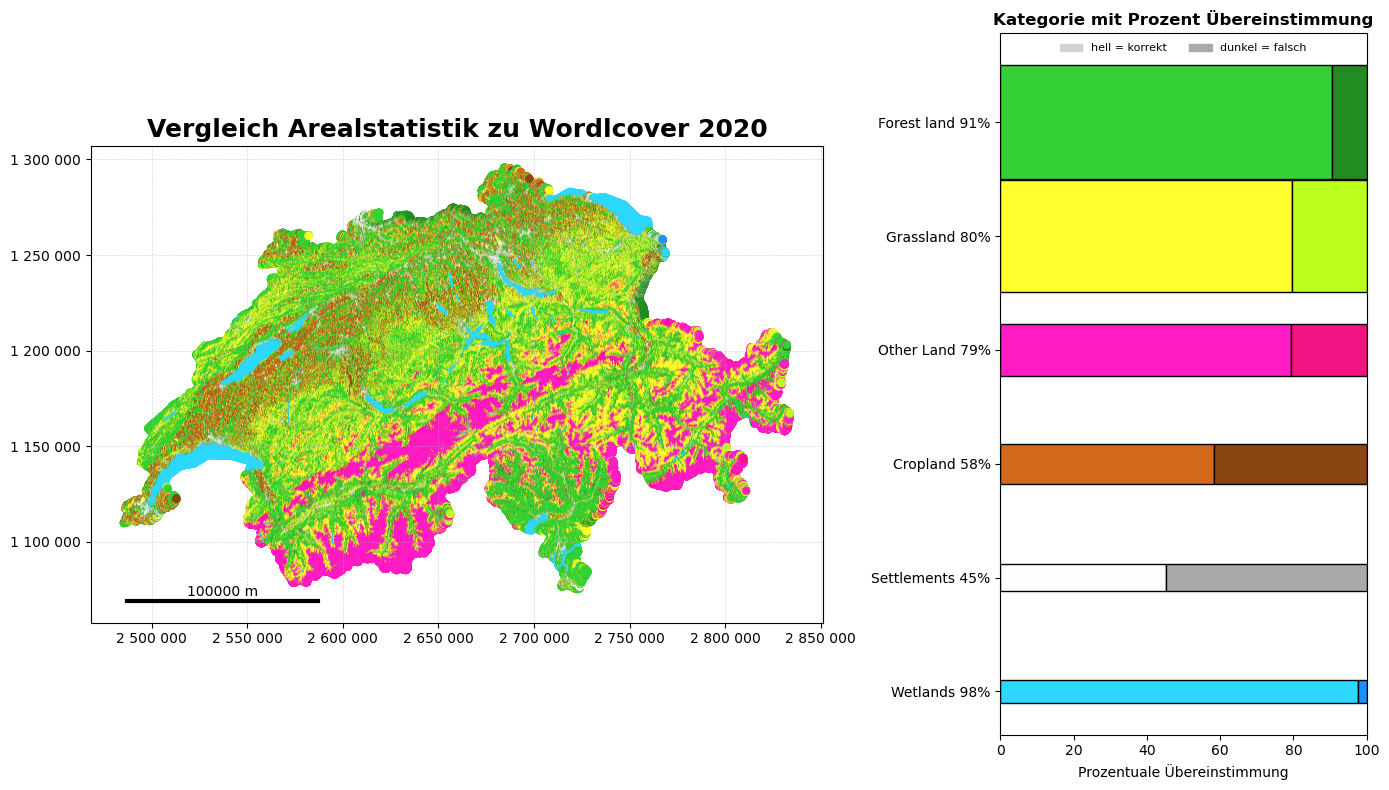

In [14]:
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\worldcover\arealstatistik_mapped_2020_center_points.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_WC_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Vergleich Arealstatistik zu Wordlcover 2020" )

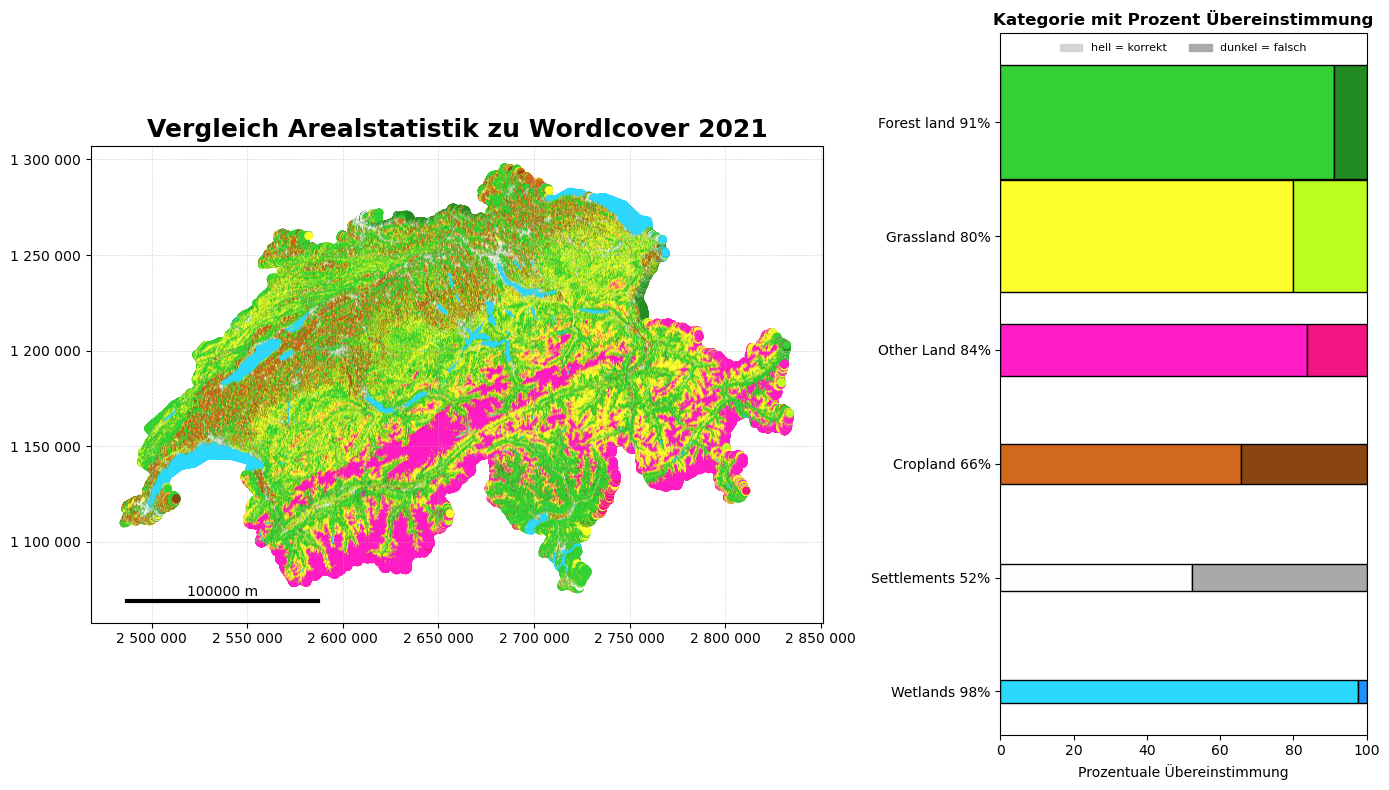

In [15]:
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\worldcover\arealstatistik_mapped_2021_center_points.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_WC_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Vergleich Arealstatistik zu Wordlcover 2021" )

c:\Users\st1179523\.conda\envs\5230_As\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: This version of GeoPackage user_version=0x000028A0 (10400, v1.4.0) on 'C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg' may only be partially supported
  return ogr_read(


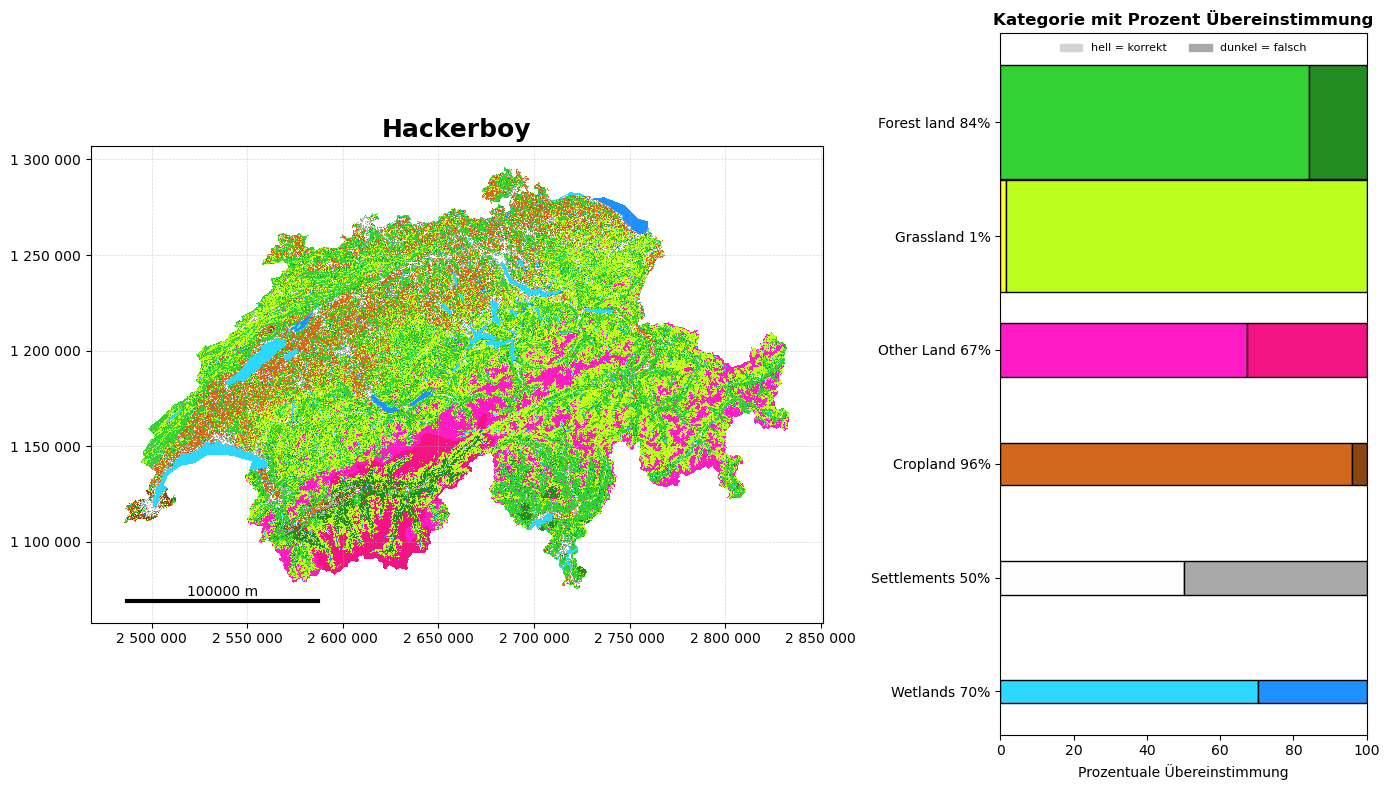

In [16]:
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_AV_Id"

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Hackerboy" )